# Stock Price Prediction with LSTM

## <a name='1'></a>Preamble

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data. Unlike traditional feedforward networks, LSTM networks are equipped with memory cells that can maintain information over extended periods, making them particularly effective for modeling time-series data like stock prices. In this project, we will utilize the Keras library to implement LSTM models for predicting stock prices based on historical closing price data of a chosen set of stocks.

Methodology:
* Historical closing price data for the selected stocks will be gathered from cvs saved by the means of the previous Jupyter Notebook file.
* Using the Keras library, we will construct LSTM models capable of learning from past trends and patterns in the stock data.
* The LSTM models will be trained on the historical data to capture temporal dependencies and understand the underlying patterns in the stock prices.
* Once trained, the LSTM models will be used to generate predictions for future stock prices. We will evaluate the performance of our models using RMSE.

## <a name='2'></a>Outline

* [Import packages](#3)
* [LSTM for Stock Price Prediction](#4)
    * [Prep Steps](#4.1)
    * [Model structure](#4.2)
    * [Prediction](#4.3)
    * [Plotting](#4.4)
* [Implementation of LSTM on the chosen set of stocks](#5)
    * [Close Price History Overview](#5.1)
    * [Prediction](#5.2)
* [Conclusions](#6)

## <a name='3'></a>Import packages

In [1]:
# Import the packages
# basic
import pandas as pd
import numpy as np

# for data plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# for data normalization
from sklearn.preprocessing import MinMaxScaler

# for machine learning 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

## <a name='4'></a>LSTM for Stock Price Prediction

To delve into LSTM (Long Short-Term Memory) method for stock price prediction, we need to load a dataset first. Let's assume that we'll be working with the set of stocks chosen in the previous Jupyter Notebook file titled "Portfolio Optimization with S&P 500 historical stock data" (Sharpe ratio maximization variant).

### <a name='4.1'></a>Prep Steps

In [2]:
# load the chosen dataset
dataset = pd.read_csv('close_price_chosen_sharpe.csv').sort_index(ascending=True, axis=0)

dataset.head()  # overview

,Date,AZO,AXON,AVGO,CMG,CHD,STZ,COST,DXCM,DPZ,...,EXR,KDP,KR,NFLX,NVDA,ORLY,ODFL,PGR,REGN,TDG
0,2010-01-04 00:00:00-05:00,158.029999,4.65,13.586246,87.839996,12.452536,14.327156,42.566841,2.1400,7.131133,...,7.447290,3.305809,7.856655,7.640000,4.240228,38.500000,8.437675,11.289371,24.629999,23.933880
1,2010-01-05 00:00:00-05:00,156.710007,4.70,13.687099,89.019997,12.284039,14.149399,42.437874,2.1725,7.196858,...,7.397181,3.267184,7.764586,7.358571,4.302147,38.560001,8.619160,11.251805,25.100000,24.161591
2,2010-01-06 00:00:00-05:00,155.240005,5.84,13.795160,87.320000,12.342911,14.336042,42.989574,2.2375,7.402248,...,7.422237,3.339889,7.768420,7.617143,4.329666,38.389999,8.777604,11.139099,24.719999,24.331160
3,2010-01-07 00:00:00-05:00,157.300003,5.66,13.708711,86.430000,12.204867,14.193838,42.781784,2.3025,7.698008,...,7.365867,3.303536,7.845150,7.485714,4.244815,38.270000,8.354134,10.988823,24.570000,24.646082
4,2010-01-08 00:00:00-05:00,155.279999,5.56,13.809561,91.889999,12.178477,13.918316,42.473698,2.2600,7.698008,...,7.203016,3.279680,7.772260,7.614286,4.253989,37.930000,8.469360,11.089007,24.370001,24.927088


It may be the case that we don't like the given datetime format that we're seeing right now in the first column of our dataframe. We'll try to change the way a datetime is displayed by defining a function below. Additionally, setting the Date column as the new dataframe index is necessary for future display/plotting.

In [3]:
# function: convert complex datetime format YYYY-MM-DD TZ ... to simple '%Y-%m-%D' in a whole column in a given dataframe
def convert_date_format_of_column(dataframe, col_name):
    list = []
    for i in range(dataframe.shape[0]):
        year = dataframe[col_name][i][0:4]
        month = dataframe[col_name][i][5:7]
        day = dataframe[col_name][i][8:10]
        new_date_format = year + '-' + month + '-' + day
        list.append(pd.Timestamp(new_date_format))
        
    new_column = pd.Series(list)
    dataframe.index = new_column
    
    return dataframe.index

In [4]:
# convert to desired format
dataset.index = dataset.Date  # setting index
convert_date_format_of_column(dataset, 'Date')
dataset.drop('Date', axis=1, inplace=True)
dataset.index.name = 'Date'

dataset.head()  # overview

,AZO,AXON,AVGO,CMG,CHD,STZ,COST,DXCM,DPZ,LLY,EXR,KDP,KR,NFLX,NVDA,ORLY,ODFL,PGR,REGN,TDG
Date,,,,,,,,,,,,,,,,,,,,
2010-01-04,158.029999,4.65,13.586246,87.839996,12.452536,14.327156,42.566841,2.1400,7.131133,23.776001,7.447290,3.305809,7.856655,7.640000,4.240228,38.500000,8.437675,11.289371,24.629999,23.933880
2010-01-05,156.710007,4.70,13.687099,89.019997,12.284039,14.149399,42.437874,2.1725,7.196858,23.357824,7.397181,3.267184,7.764586,7.358571,4.302147,38.560001,8.619160,11.251805,25.100000,24.161591
2010-01-06,155.240005,5.84,13.795160,87.320000,12.342911,14.336042,42.989574,2.2375,7.402248,23.530409,7.422237,3.339889,7.768420,7.617143,4.329666,38.389999,8.777604,11.139099,24.719999,24.331160
2010-01-07,157.300003,5.66,13.708711,86.430000,12.204867,14.193838,42.781784,2.3025,7.698008,23.410929,7.365867,3.303536,7.845150,7.485714,4.244815,38.270000,8.354134,10.988823,24.570000,24.646082
2010-01-08,155.279999,5.56,13.809561,91.889999,12.178477,13.918316,42.473698,2.2600,7.698008,23.231712,7.203016,3.279680,7.772260,7.614286,4.253989,37.930000,8.469360,11.089007,24.370001,24.927088


In [5]:
# basic information about the dataframe
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3569 entries, 2010-01-04 to 2024-03-08
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AZO     3569 non-null   float64
 1   AXON    3569 non-null   float64
 2   AVGO    3569 non-null   float64
 3   CMG     3569 non-null   float64
 4   CHD     3569 non-null   float64
 5   STZ     3569 non-null   float64
 6   COST    3569 non-null   float64
 7   DXCM    3569 non-null   float64
 8   DPZ     3569 non-null   float64
 9   LLY     3569 non-null   float64
 10  EXR     3569 non-null   float64
 11  KDP     3569 non-null   float64
 12  KR      3569 non-null   float64
 13  NFLX    3569 non-null   float64
 14  NVDA    3569 non-null   float64
 15  ORLY    3569 non-null   float64
 16  ODFL    3569 non-null   float64
 17  PGR     3569 non-null   float64
 18  REGN    3569 non-null   float64
 19  TDG     3569 non-null   float64
dtypes: float64(20)
memory usage: 585.5 KB


In [6]:
# shape of the dataframe (rows x columns)
dataset.shape

(3569, 20)

For now, let's explore the functionality of LSTM algotithm on 'CAH' only.

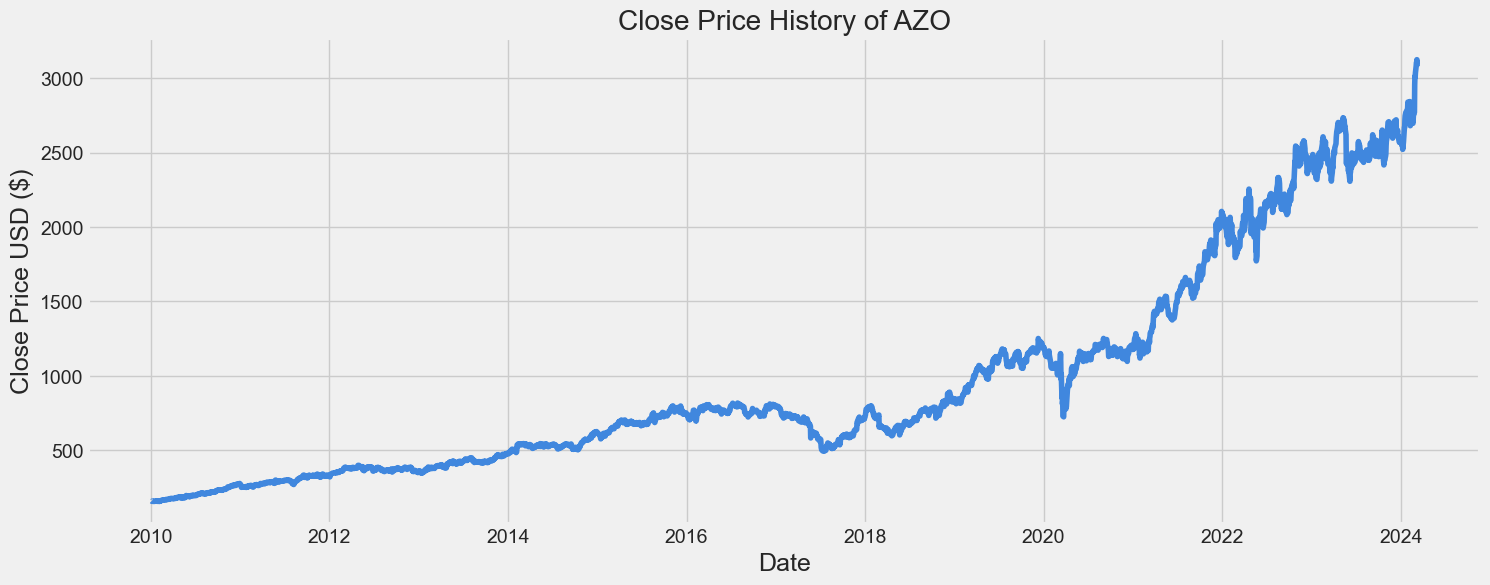

In [8]:
# ticker name
ticker_name = 'AZO'

# show close price history ot the ticker
plt.figure(figsize=(16,6))
plt.title('Close Price History of {}'.format(ticker_name))
plt.plot(dataset[ticker_name], color='#4087de')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

plt.show()

Next, we'll split our dataframe into required sets. Data used to train our model will account for 95% of the whole set.

In [9]:
# get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95 ))

training_data_len  # overview

3391

In [10]:
# convert the dataframe to numpy array
dataset_ticker = dataset.filter([ticker_name])
dataset_array = dataset_ticker.values

# create train and test sets
training_set = dataset_array[0:training_data_len]
test_set = dataset_array[training_data_len:]

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_training_set = scaler.fit_transform(dataset_array)

scaled_training_set[0:5]  # overview of the scaled dataset

array([[0.00122911],
       [0.00078461],
       [0.0002896 ],
       [0.00098329],
       [0.00030307]])

In [11]:
# create the training data set 
# create the scaled training data set
train_data = scaled_training_set[0:int(training_data_len), :]

# split into x_train and y_train data sets
X_train = []
Y_train = []

for i in range(60, len(train_data)):  # 60: timestep // length of the data
    X_train.append(train_data[i - 60:i, 0])
    Y_train.append(train_data[i, 0])
    if i <= 61:
        print(X_train)
        print(Y_train)
        print()

# convert to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)  # the target data

# reshape the data (number of samples, number of time steps, number of features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # the input data

[array([1.22910729e-03, 7.84610146e-04, 2.89598573e-04, 9.83286862e-04,
       3.03066003e-04, 3.70413433e-04, 2.55922288e-04, 1.24593002e-04,
       0.00000000e+00, 2.35718573e-04, 9.76550578e-04, 6.70113863e-04,
       9.93388720e-04, 5.01742719e-04, 6.93688290e-04, 1.33349658e-03,
       6.73484574e-04, 3.50209718e-04, 2.18880431e-04, 7.13892005e-04,
       1.07757429e-03, 9.12568721e-04, 6.73114618e-06, 3.36742287e-04,
       8.62059433e-04, 1.57258586e-03, 1.38737658e-03, 1.43788587e-03,
       2.17872301e-03, 3.53242330e-03, 3.78498002e-03, 2.96669873e-03,
       3.12833359e-03, 2.92629130e-03, 3.32027916e-03, 3.56273402e-03,
       3.93988373e-03, 3.88936931e-03, 3.91294373e-03, 3.48865030e-03,
       3.43140473e-03, 4.45846459e-03, 4.85245245e-03, 4.63693760e-03,
       4.53928459e-03, 4.61673388e-03, 4.80867945e-03, 4.88612874e-03,
       4.92317059e-03, 4.98041617e-03, 5.93339746e-03, 6.00411560e-03,
       6.02768489e-03, 6.67086389e-03, 6.96046246e-03, 6.46208531e-03,
     

### <a name='4.2'></a>Model structure

Our focuse shifts now to creating and fitting the LSTM network.

In [13]:
# adding different layers to LSTM
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# each unit has 20% chance of being dropped (its value is set to zero)
regressor.add(Dropout(0.2))  # form of regularization, prevents overfitting

regressor.add(LSTM(units=50, return_sequences=True))  # units as cells
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

# fitting the model
# model compilation for optimization algorithm and loss function to be minimized
regressor.compile(optimizer='adam', loss='mean_squared_error')  # prepares the model for training
regressor.fit(X_train, Y_train, epochs=100, batch_size=32)  # train on a given dataset // 32: no. of samples to be processed at once during training

Epoch 1/100
105/105 [==============================] - 14s 63ms/step - loss: 0.0044
Epoch 2/100
105/105 [==============================] - 7s 63ms/step - loss: 0.0015
Epoch 3/100
105/105 [==============================] - 7s 63ms/step - loss: 0.0016
Epoch 4/100
105/105 [==============================] - 7s 62ms/step - loss: 0.0011
Epoch 5/100
105/105 [==============================] - 7s 63ms/step - loss: 0.0013
Epoch 6/100
105/105 [==============================] - 7s 65ms/step - loss: 0.0011
Epoch 7/100
105/105 [==============================] - 7s 69ms/step - loss: 9.4359e-04
Epoch 8/100
105/105 [==============================] - 7s 64ms/step - loss: 9.9363e-04
Epoch 9/100
105/105 [==============================] - 7s 67ms/step - loss: 9.9382e-04
Epoch 10/100
105/105 [==============================] - 7s 66ms/step - loss: 0.0010
Epoch 11/100
105/105 [==============================] - 7s 63ms/step - loss: 8.2123e-04
Epoch 12/100
105/105 [==============================] - 7s 68ms/step

### <a name='4.3'></a>Prediction

In [14]:
# create the testing data set
# create a new array containing scaled values
test_data = scaled_training_set[training_data_len - 60: , :]

# create the data sets x_test and y_test
X_test = []
Y_test = dataset_array[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    
# convert to numpy array
X_test = np.array(X_test)

# reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predict the values
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)  # undo the scaling transformation

predicted_stock_price[0:5]  # overview

6/6 [==============================] - 2s 28ms/step


array([[2400.8525],
       [2400.3828],
       [2400.3472],
       [2399.0312],
       [2400.5413]], dtype=float32)

In [15]:
# get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predicted_stock_price - Y_test) ** 2)))

rmse  # overview

113.88269128168034

In [16]:
# evaluate the performance
print("On average, the model's predictions are off by approximately {}.".format(rmse.round(2)))

On average, the model's predictions are off by approximately 113.88.


### <a name='4.4'></a>Plotting

In [17]:
# plot the data
train = dataset_ticker[:training_data_len]
valid = dataset_ticker[training_data_len:]

In [18]:
pd.options.mode.chained_assignment = None  # default='warn'  # disable SettingWithCopyWarning

# add predictions as a column
valid.loc[:, 'Predictions'] = predicted_stock_price

In [19]:
train.head()  # overview

,AZO
Date,
2010-01-04,158.029999
2010-01-05,156.710007
2010-01-06,155.240005
2010-01-07,157.300003
2010-01-08,155.279999


In [20]:
valid.head()  # overview

,AZO,Predictions
Date,,
2023-06-26,2476.550049,2400.852539
2023-06-27,2439.879883,2400.382812
2023-06-28,2437.629883,2400.347168
2023-06-29,2455.399902,2399.031250
2023-06-30,2493.360107,2400.541260


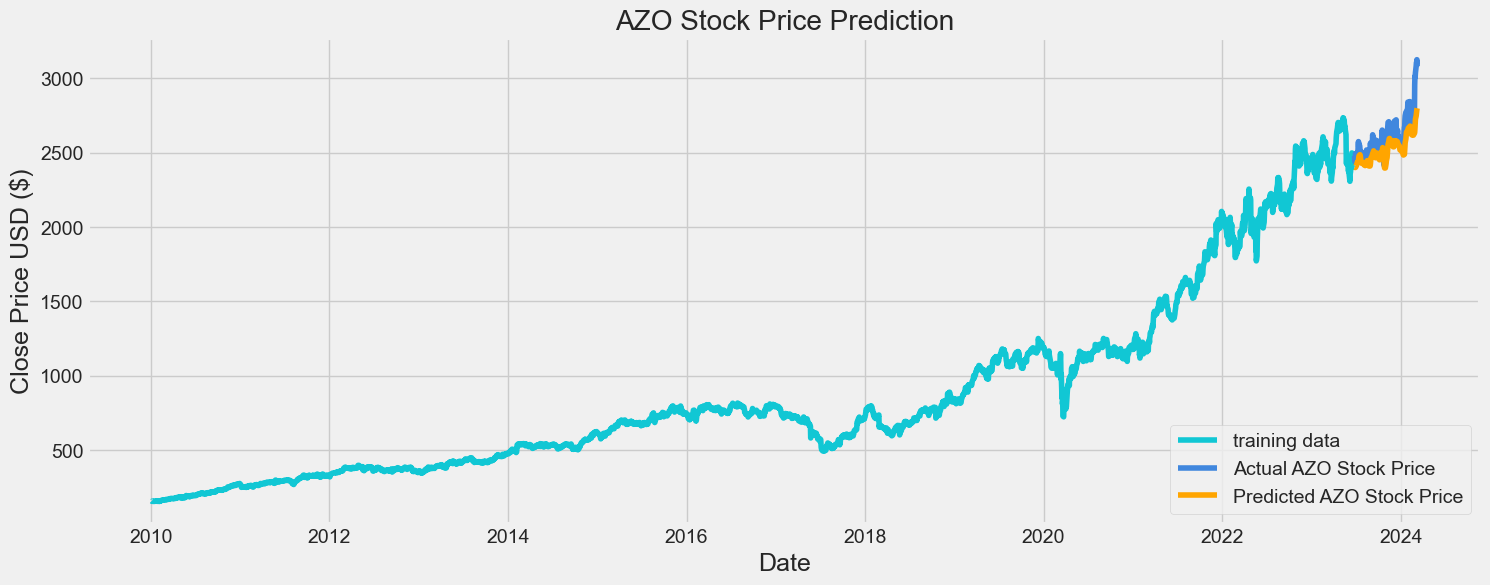

In [21]:
# visualize the data
plt.figure(figsize=(16,6))
plt.title('{} Stock Price Prediction'.format(ticker_name))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train[ticker_name], color='#11c7d4')
plt.plot(valid[ticker_name], color='#4087de')
plt.plot(valid['Predictions'], color='orange')
plt.legend(['training data', 'Actual {} Stock Price'.format(ticker_name), 'Predicted {} Stock Price'.format(ticker_name)], loc='lower right')

plt.show()

In [22]:
valid.iloc[-1, :]  # check last pair of predicted and actual price

AZO            3079.489990
Predictions    2797.689453
Name: 2024-03-08 00:00:00, dtype: float64

In [23]:
#predicting next data stock price
myinputs = predicted_stock_price[-1]
myinputs = np.reshape(myinputs, (1, 1, 1))

myinputs

array([[[2797.6895]]], dtype=float32)

In [24]:
# make predictions
yhat = regressor.predict(myinputs, verbose=0)
yhat = scaler.inverse_transform(yhat) 

print(yhat)

[[1784.6876]]


## <a name='5'></a>Implementation of LSTM on the chosen set of stocks

Let assume that our intention is to implement LSTM algorithm on a defined set of stocks.

In [29]:
# define list of ticker names
col_chosen = dataset.columns[-3:]

### <a name='5.1'></a>Close Price History Overview

To begin, let's find out how the history of closing prices evolved over the analyzed timeframe.

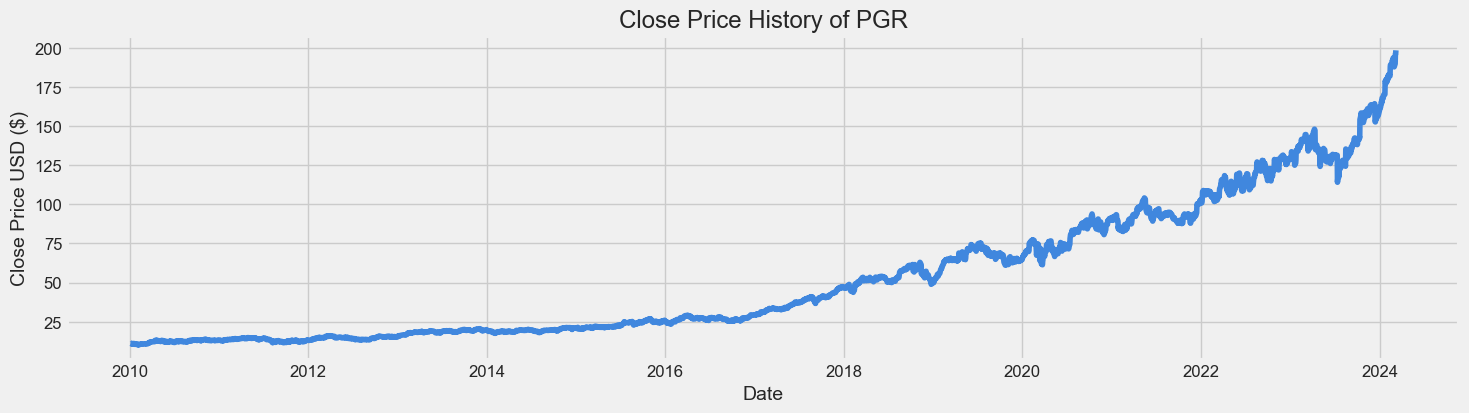

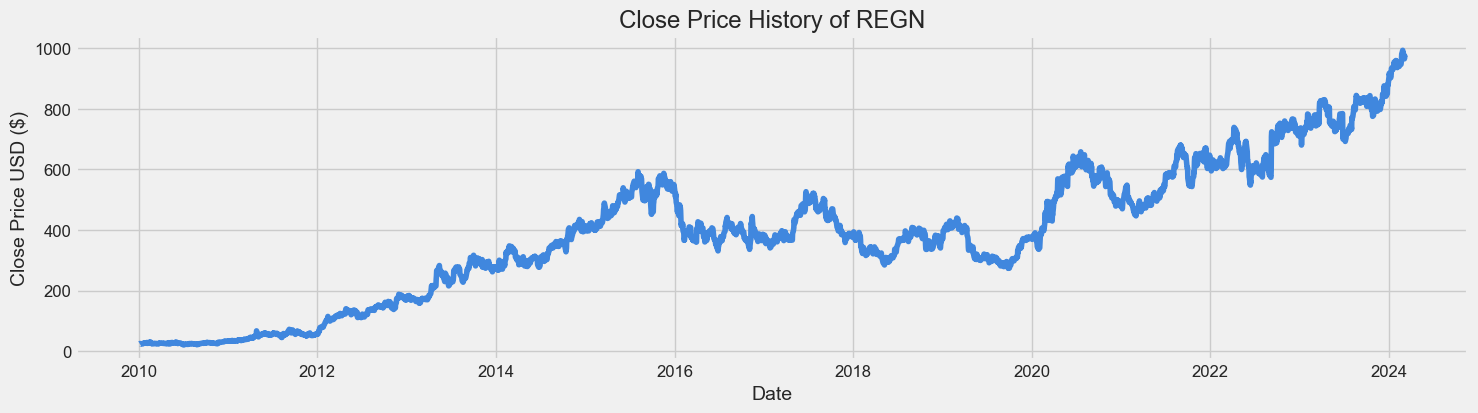

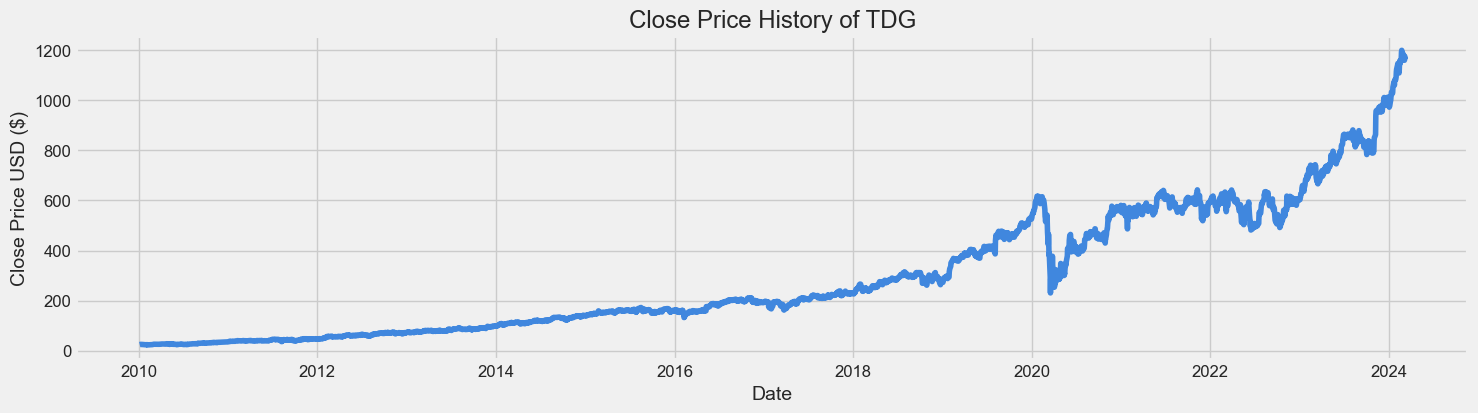

In [30]:
# change font size
plt.rcParams.update({'font.size': 12})

# plot close price history of the chosen stocks
for i in col_chosen:
    plt.figure(figsize=(16,4))
    plt.title('Close Price History of {}'.format(i))
    plt.plot(dataset[i], color='#4087de')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close Price USD ($)', fontsize=14)
    
    plt.show()      

### <a name='5.2'></a>Prediction

For the next part, we'll enhance the code to analyze all the chosen stocks by defining a function.

In [31]:
# function: implement ML algorithm (LSTM) on a given list of stocks 
def predict_price_LSTM(list_of_tickers, csv_name):
    # load the training dataset
    ds = pd.read_csv(csv_name).sort_index(ascending=True, axis=0)
    
    # convert to desired format
    ds.index = ds.Date  # setting index
    convert_date_format_of_column(ds, 'Date')
    ds.drop('Date', axis=1, inplace=True)
    ds.index.name = 'Date'  

    # get the number of rows to train the model on
    training_data_len = int(np.ceil(len(ds) * .95 ))
    
    # set up for normalization
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    
    for i in list_of_tickers:
        # convert the dataframe to numpy array
        ds_i = ds.filter([i])
        ds_array = ds_i.values

        # create train and test sets
        training_set = ds_array[0:training_data_len]
        test_set = ds_array[training_data_len:]
        
        # normalize the dataset
        scaled_training_set = scaler.fit_transform(ds_array)

        
        # create the training data set 
        # create the scaled training data set
        train_data = scaled_training_set[0:int(training_data_len), :]

        # split into x_train and y_train data sets
        X_train = []
        Y_train = []

        for j in range(60, len(train_data)):  # 60: timestep // length of the data
            X_train.append(train_data[j - 60:j, 0])
            Y_train.append(train_data[j, 0])

        # convert to numpy arrays
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)  # the target data

        # reshape the data (number of samples, number of time steps, number of features)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # the input data
        
        
        # design LSTM network
        regressor = Sequential()

        regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        # each unit has 20% chance of being dropped (its value is set to zero)
        regressor.add(Dropout(0.2))  # form of regularization, prevents overfitting

        regressor.add(LSTM(units=50, return_sequences=True))  # units as cells
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units=50))
        regressor.add(Dropout(0.2))

        regressor.add(Dense(units=1))

        # fitting the model
        regressor.compile(optimizer='adam', loss='mean_squared_error')  # prepares the model for training
        regressor.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)  # train on a given dataset
        
        
        # create the testing data set
        # create a new array containing scaled values
        test_data = scaled_training_set[training_data_len - 60: , :]

        # create the data sets x_test and y_test
        X_test = []
        Y_test = ds_array[training_data_len:, :]
        for j in range(60, len(test_data)):
            X_test.append(test_data[j-60:j, 0])

        # convert to numpy array
        X_test = np.array(X_test)

        # reshape the data
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # predict the values
        predicted_stock_price = regressor.predict(X_test)
        predicted_stock_price = scaler.inverse_transform(predicted_stock_price)  # undo the scaling transformation

        # get the root mean squared error (RMSE)
        rmse = np.sqrt(np.mean(((predicted_stock_price - Y_test) ** 2)))
        # evaluate the performance
        print("On average, the model's predictions for {} are off by approximately {}.".format(i, rmse.round(2)))
        
        # plot the data
        train = ds_i[:training_data_len]
        valid = ds_i[training_data_len:]
        valid.loc[:, 'Predictions'] = predicted_stock_price
        
        print("Last prediction: \n", valid.iloc[-1, :])  # check last pair of predicted and actual price
        
        # visualize the data
        plt.figure(figsize=(16,4))
        plt.title('{} Stock Price Prediction'.format(i))
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Close Price USD ($)', fontsize=14)
        plt.plot(train[i], color='#11c7d4')
        plt.plot(valid[i], color='#4087de')
        plt.plot(valid['Predictions'], color='orange')
        plt.legend([f'training data', f'Actual {i} Stock Price', f'Predicted {i} Stock Price'], loc='lower right')
        
        plt.show()

6/6 [==============================] - 2s 25ms/step
On average, the model's predictions for PGR are off by approximately 14.07.
Last prediction: 
 PGR            198.410004
Predictions    160.365982
Name: 2024-03-08 00:00:00, dtype: float64


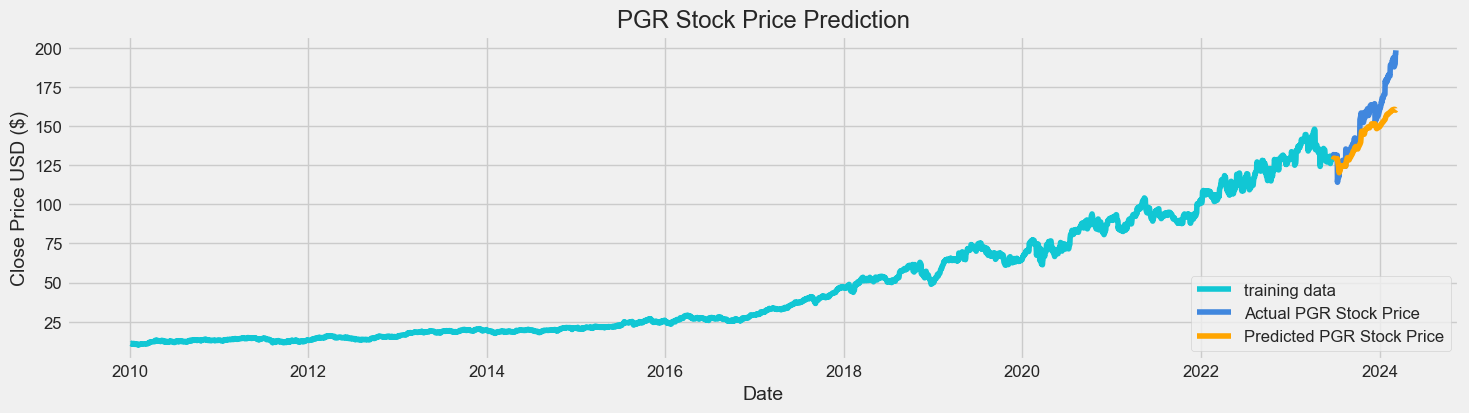

6/6 [==============================] - 2s 28ms/step
On average, the model's predictions for REGN are off by approximately 24.39.
Last prediction: 
 REGN           968.830017
Predictions    942.697693
Name: 2024-03-08 00:00:00, dtype: float64


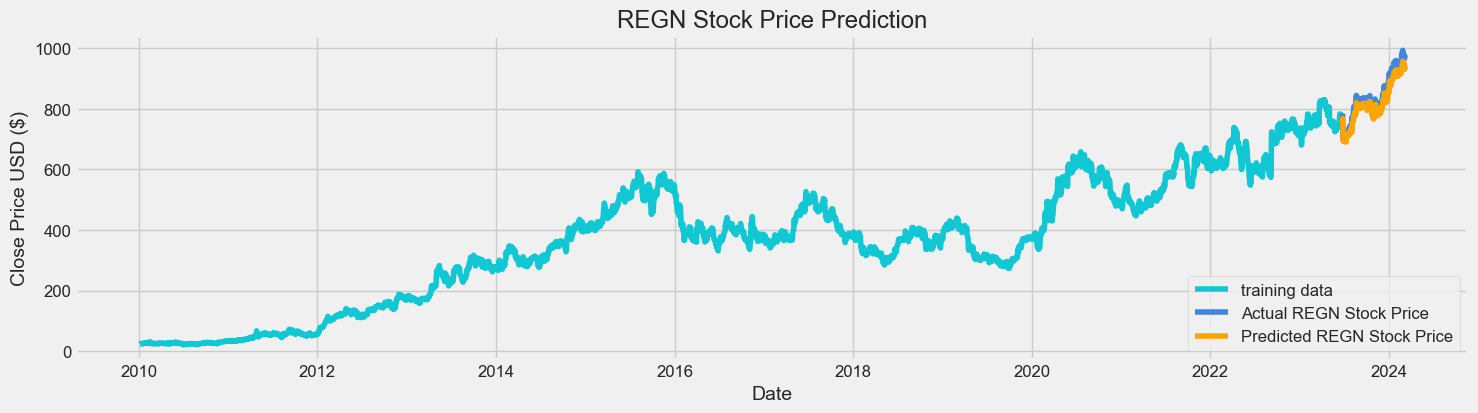

6/6 [==============================] - 2s 28ms/step
On average, the model's predictions for TDG are off by approximately 53.9.
Last prediction: 
 TDG            1164.98999
Predictions    1066.63208
Name: 2024-03-08 00:00:00, dtype: float64


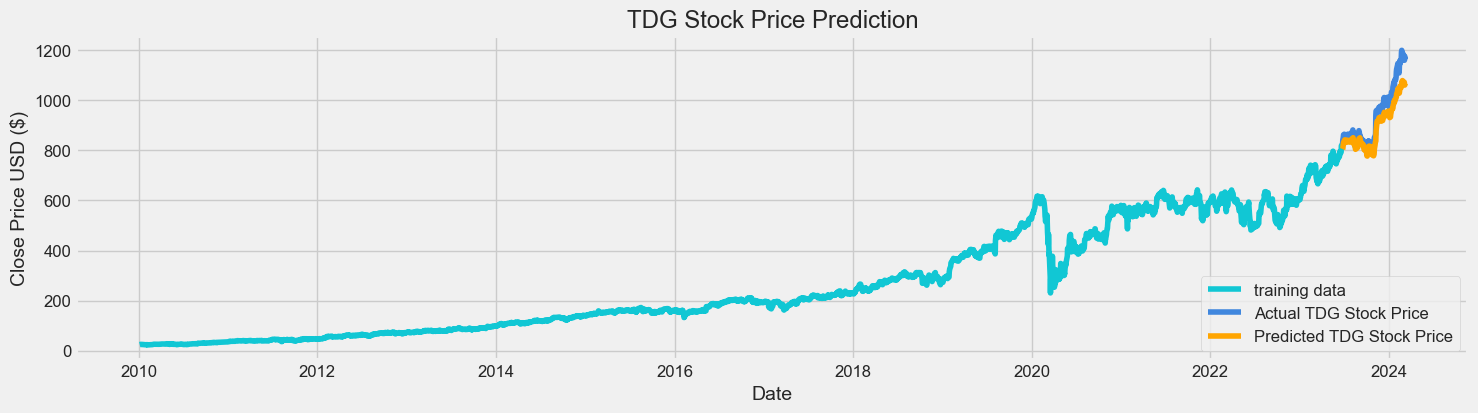

In [32]:
# use the defined function
predict_price_LSTM(col_chosen, 'close_price_chosen_sharpe.csv')

## <a name='6'></a>Conclusions

* The plotted charts have provided us with insight into how LSTM can predict stock prices, and the results appear promising.
* By combining the power of LSTM networks with the ease of implementation offered by Keras, we can develop efficient and effective solutions for stock price prediction, contributing to the advancement of predictive analytics in the financial domain.
* It's crucial to acknowledge that no model can guarantee perfect accuracy, and understanding its limitations is key to making informed decisions based on the predictions provided.